<a href="https://colab.research.google.com/github/PedroFlorencioNeto/visgeo/blob/main/InfraestruturaCicloviariaPYNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1mzSvyk5ZQgvHUqmLfA8suncoq-0Ms1ll)

---
<center><h3></h3>
<h3><b>Visualização e Processamento de Dados Geoespaciais: Acessibilidade a Malha Cicloviária<br><h4><b>Python Nordeste 2024</b></h4></b></h3></center>


<br>Este notebook tem como objetivo apresentar de forma prática os principais métodos e conceitos sobre geoprocessamento de dados e visualização de mapas aos participantes do Python Nordeste 2024.

**Autor:** Pedro Florencio de Almeida Neto - Cientista de Dados @Ipplan
| @BioData (UFC)

**Contato:** <i>pedroflorencio@alu.ufc.br</i>

---

**Objetivo:** Calcular e visualizar o indicador PNB nos bairros de Natal-RN.

#### **1. Contextualização**

O indicador *People Near Bike Lanes* (PNB), desenvolvido pelo *Institute for Transportation and Development Policy* (ITDP), foi criado para medir a acessibilidade das infraestruturas de ciclovias e a proximidade da população a essas vias, com o objetivo de promover políticas públicas e planejamentos urbanos que incentivem o uso da bicicleta como um meio de transporte sustentável, acessível e seguro.

Neste tutorial, você aprenderá a calcular e visualizar o comportamento do indicador no seu município, permitindo assim monitorar a acessibilidade à infraestrutura em todos os bairros.

#### **2. Metodologia**

O **PNB** é definido matematicamente como a **proporção da população que vive a pelo menos 300 metros de uma infraestrutura cicloviária**, sendo um valor de varia de 0 a 1, isto é, de 0 a 100% da população.

$PNB = \frac{populacao_{proxima}}{populacao_{total}}$ [1]

Sendo:

- **populacao_proxima**: Número de pessoas em que suas habitações estão contidas em um raio de até 300 metros de infraestrutura cicloviária.
- **populacao_total**: Número total de pessoas no espaço avaliado, podendo ser bairro, município, subdistrito, entre outros.

Para **estimativa da população contida no raio de 300 metros**, utiliza-se como unidade territorial os microdados de **setores censitários** disponibilizados pelo IBGE, que correspondem a menor porção em que o território é fragmentado no Brasil e que se é possível determinar o número de habitantes. Como a infraestrutura cicloviária e seu raio podem dividir um setor censitário, é considerada uma premissa como aproximação: de que a população é distribuída de maneira uniforme em todo o espaço do setor censitário em avaliação, sendo calculada a relação de área para determinação da população dos polígonos divididos.

A **Malha Preliminar de Setores Censitários** foram adquiridas através do site do [IBGE](https://www.ibge.gov.br/estatisticas/sociais/populacao/22827-censo-demografico-2022.html?edicao=39499&t=resultados), em tabelas divulgadas no dia 21/03/2024.

> **Fontes dos dados:**
- Limites dos bairros de Natal | [Address For All](https://www.addressforall.org/en/downloads/#Brazil)
- Infraestrutura cicloviária de Natal | [Google My Maps](https://www.google.com/maps/d/u/0/viewer?mid=1x474AeGEWUAAcvDTgS_fxg-J0Hg&femb=1&ll=-5.840903345747478%2C-35.22957610949073&z=12)
- População dos setores censitários | [IBGE](https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios_preliminares/agregados_por_setores_csv/UF/#:~:text=14M-,Agregados_preliminar..%3E,-2024%2D03%2D20)
- Malha de setores censitários | [IBGE](https://www.ibge.gov.br/geociencias/downloads-geociencias.html?caminho=organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2022_preliminar/setores/gpkg/UF)

#### **3. Bibliotecas**

In [1]:
!pip install -q mapclassify
!pip3 install -q contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.9 MB/s eta 0:00:00


In [2]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import folium.plugins
import geopandas as gpd
import contextily as cx
import plotly.express as px
from google.colab import drive
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors

drive.mount('/gdrive', force_remount=True)

%matplotlib inline

Mounted at /gdrive


#### **4. Aquisição dos Dados**

**Instruções:**

1. Solicitar acesso à pasta **[PyNE](https://drive.google.com/drive/folders/1Ac-fpV8r78gc6IKm8JfORZNNZJegiKSt?usp=drive_link)**;
2. Clicar com o botão direito e criar um **atalho** para Meu Drive | *My Drive*.

In [3]:
# caminho para os dados brutos
caminho_dados = '/gdrive/MyDrive/PyNE/dados_brutos/'

# setores censitarios do Rio Grande do Norte
df_setores = pd.read_csv(caminho_dados+'agregados_preliminares_por_setores_censitarios_RN.csv', sep=';')

# malha georreferenciada de setores censitarios
gdf_setores = gpd.read_file(caminho_dados+'RN_malha_preliminar_2022.gpkg', crs='EPSG:4326', driver='GPKG')

# limites dos bairros de Natal
gdf_bairros = gpd.read_file(caminho_dados+'bairros_natal/bairros.shp', crs='EPSG:4326')

# infraestrutura cicloviaria
gdf_infraestrutura = gpd.read_file(caminho_dados+'infraestrutura_cicloviaria_natal.geojson', crs='EPSG:4326')

**Objetos de interesse:**

- `gdf_bairros`: GeoDataframe dos bairros de Natal.
- `df_setores`: DataFrame dos setores censitarios do Rio Grande do Norte.
- `gdf_setores`: GeoDataFrame da malha de setores censitarios do Rio Grande do Norte.
- `gdf_infraestrutura`: GeoDataFrame do mapa cicloviário de Natal.




#### **5. Entendimento dos Dados**

##### **5.1. Setores Censitários**

In [4]:
df_setores.head()

CD_SETOR  AREA_KM2  CD_REGIAO NM_REGIAO  CD_UF  \
0  240010905000001P  0.342964          2  Nordeste     24   
1  240010905000002P  0.707408          2  Nordeste     24   
2  240010905000003P  0.062812          2  Nordeste     24   
3  240010905000004P  0.176762          2  Nordeste     24   
4  240010905000005P  0.226327          2  Nordeste     24   

                 NM_UF   CD_MUN NM_MUN    CD_DIST NM_DIST  ...  NM_RGINT  \
0  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
1  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
2  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
3  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
4  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   

  CD_CONCURB  NM_CONCURB v0001  v0002 v0003  v0004     v0005     v0006 v0007  
0        NaN         NaN   246    117   117      0  2.733333  4.444444    90  
1        NaN         NaN   728    300   300      0  2.854902  0.784314   255  
2        NaN         NaN   665    276   276      0  2.736626  0.823045   243  
3        NaN         NaN   309    118   118      0  2.942857  0.952381   105  
4        NaN         NaN   554    225   224      1  2.826531  0.000000   196  

[5 rows x 29 columns]

In [5]:
df_setores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5975 entries, 0 to 5974
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CD_SETOR    5975 non-null   object 
 1   AREA_KM2    5975 non-null   float64
 2   CD_REGIAO   5975 non-null   int64  
 3   NM_REGIAO   5975 non-null   object 
 4   CD_UF       5975 non-null   int64  
 5   NM_UF       5975 non-null   object 
 6   CD_MUN      5975 non-null   int64  
 7   NM_MUN      5975 non-null   object 
 8   CD_DIST     5975 non-null   int64  
 9   NM_DIST     5975 non-null   object 
 10  CD_SUBDIST  5975 non-null   int64  
 11  NM_SUBDIST  5975 non-null   object 
 12  CD_MICRO    5975 non-null   int64  
 13  NM_MICRO    5975 non-null   object 
 14  CD_MESO     5975 non-null   int64  
 15  NM_MESO     5975 non-null   object 
 16  CD_RGI      5975 non-null   int64  
 17  NM_RGI      5975 non-null   object 
 18  CD_RGINT    5975 non-null   int64  
 19  NM_RGINT    5975 non-null  

**Dicionário de Dados - Setores Censitários**

| Variável        | Tipo      | Tamanho | Descrição                                                             |
|-----------------|-----------|---------|-----------------------------------------------------------------------|
| CD_SETOR        | texto     | 16      | Geocódigo de Setor Censitário                                        |
| AREA_KM2        | real      |         | Área do Setor Censitário em quilômetros quadrados                    |
| CD_REGIAO       | numérico  | 1       | Código das Grandes Regiões (Regiões Geográficas)                      |
| NM_REGIAO       | texto     | 15      | Nome das Grandes Regiões (Regiões Geográficas)                        |
| CD_UF           | numérico  | 2       | Código da Unidade da Federação                                        |
| NM_UF           | texto     | 20      | Nome da Unidade da Federação                                          |
| CD_MUN          | numérico  | 7       | Código do município                                                   |
| NM_MUN          | texto     | 50      | Nome do município                                                     |
| CD_DIST         | numérico  | 9       | Código do distrito                                                    |
| NM_DIST         | texto     | 50      | Nome do distrito                                                      |
| CD_SUBDIS       | numérico  | 11      | Código do subdistrito                                                  |
| NM_SUBDIST      | texto     | 50      | Nome do subdistrito                                                    |
| CD_MICRO        | numérico  | 5       | Código da microrregião                                                 |
| NM_MICRO        | texto     | 50      | Nome da microrregião                                                   |
| CD_MESO         | numérico  | 4       | Código da mesorregião                                                  |
| NM_MESO         | texto     | 50      | Nome da mesorregião                                                    |
| CD_RGI          | numérico  | 6       | Código da região geográfica imediata                                   |
| NM_RGI          | texto     | 50      | Nome da região geográfica imediata                                     |
| CD_RGINT        | numérico  | 4       | Código da região geográfica intermediária                             |
| NM_RGINT        | texto     | 50      | Nome da região geográfica intermediária                               |
| CD_CONCURB      | numérico  | 7       | Código da Concentração Urbana                                          |
| NM_CONCURB      | texto     | 50      | Nome da Concentração Urbana                                            |
| V0001           | numérico  |         | Total de pessoas                                                       |
| V0002           | numérico  |         | Total de Domicílios (DPPO + DPPV + DPPUO + DPIO + DCCM + DCSM)        |
| V0003           | numérico  |         | Total de Domicílios Particulares (DPPO + DPPV + DPPUO + DPIO)          |
| V0004           | numérico  |         | Total de Domicílios Coletivos (DCCM + DCSM)                            |
| V0005           | real      |         | Média de moradores em Domicílios Particulares Ocupados (Total pessoas em Domicílios Particulares Ocupados / DPPO + DPIO)     |
| V0006           | real      |         | Percentual de Domicílios Particulares Ocupados Imputados (Total DPO imputados / Total DPO) |
| V0007           | numérico  |         | Total de Domicílios Particulares Ocupados (DPPO + DPIO)                |


##### **5.2. Limites dos bairros de Natal**

In [6]:
gdf_bairros.head(2)

BAIRRO REG_ADM  N_ Coeficient                                Lei_n_  \
0          Rocas   Leste  09        2,5  LEI Nº 4.330, DE 05 DE ABRIL DE 1993   
1  Praia do Meio   Leste  11        2,5      LEI N  4328, DE 05 ABRIL DE 1993   

            Area       Hectares  Renda_2000  Renda_2010  Pop_1991  ...  \
0  660154.266458  660154.266458         0.0         0.0   12316.0  ...   
1  489175.242290  489175.242290         0.0         0.0    3304.0  ...   

   Pop_2010      Pop_2011      Pop_2012      Pop_2013  Pop_2014  Pop_2015  \
0   10452.0  10446.377797  10440.940047  10371.893329   10358.0   10347.0   
1    4770.0   4814.438505   4857.419079   5152.240479    5214.0    5274.0   

   Pop_2016  Pop_2017  Pop_2018  \
0   10334.0   10322.0   10334.0   
1    5333.0    5390.0    5333.0   

                                            geometry  
0  POLYGON ((256848.065 9361403.003, 256791.200 9...  
1  POLYGON ((257073.088 9361374.537, 257074.693 9...  

[2 rows x 25 columns]

In [7]:
gdf_bairros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BAIRRO      37 non-null     object  
 1   REG_ADM     37 non-null     object  
 2   N_          37 non-null     object  
 3   Coeficient  16 non-null     object  
 4   Lei_n_      37 non-null     object  
 5   Area        37 non-null     float64 
 6   Hectares    37 non-null     float64 
 7   Renda_2000  37 non-null     float64 
 8   Renda_2010  37 non-null     float64 
 9   Pop_1991    37 non-null     float64 
 10  Pop_1996    37 non-null     float64 
 11  Pop_2000    37 non-null     float64 
 12  Pop_2007    37 non-null     float64 
 13  Pop_2008    37 non-null     float64 
 14  Pop_2009    37 non-null     float64 
 15  Pop_2010    37 non-null     float64 
 16  Pop_2011    37 non-null     float64 
 17  Pop_2012    37 non-null     float64 
 18  Pop_2013    37 non-null     float64 
 19  Po

##### **5.3. Malha georreferenciada de setores censitários**

In [8]:
gdf_setores.head()

CD_SETOR  AREA_KM2 CD_REGIAO NM_REGIAO CD_UF                NM_UF  \
0  240010905000001P  0.342964         2  Nordeste    24  Rio Grande do Norte   
1  240010905000002P  0.707408         2  Nordeste    24  Rio Grande do Norte   
2  240010905000003P  0.062812         2  Nordeste    24  Rio Grande do Norte   
3  240010905000004P  0.176762         2  Nordeste    24  Rio Grande do Norte   
4  240010905000005P  0.226327         2  Nordeste    24  Rio Grande do Norte   

    CD_MUN NM_MUN    CD_DIST NM_DIST  ...         NM_MICRO CD_MESO  \
0  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
1  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
2  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
3  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
4  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   

            NM_MESO  CD_RGI         NM_RGI CD_RGINT NM_RGINT CD_CONCURB  \
0  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
1  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
2  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
3  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
4  Central Potiguar  240008  Currais Novos     2402    Caicó       None   

  NM_CONCURB                                           geometry  
0       None  POLYGON ((-36.64111 -6.43994, -36.64053 -6.440...  
1       None  POLYGON ((-36.64451 -6.42909, -36.64482 -6.432...  
2       None  POLYGON ((-36.64200 -6.43543, -36.64210 -6.436...  
3       None  POLYGON ((-36.64027 -6.42770, -36.64214 -6.428...  
4       None  POLYGON ((-36.63584 -6.43231, -36.63625 -6.433...  

[5 rows x 23 columns]

In [9]:
gdf_setores.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5976 entries, 0 to 5975
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CD_SETOR    5976 non-null   object  
 1   AREA_KM2    5976 non-null   float64 
 2   CD_REGIAO   5976 non-null   object  
 3   NM_REGIAO   5976 non-null   object  
 4   CD_UF       5976 non-null   object  
 5   NM_UF       5976 non-null   object  
 6   CD_MUN      5976 non-null   object  
 7   NM_MUN      5976 non-null   object  
 8   CD_DIST     5976 non-null   object  
 9   NM_DIST     5976 non-null   object  
 10  CD_SUBDIST  5976 non-null   object  
 11  NM_SUBDIST  1116 non-null   object  
 12  CD_MICRO    5976 non-null   object  
 13  NM_MICRO    5976 non-null   object  
 14  CD_MESO     5976 non-null   object  
 15  NM_MESO     5976 non-null   object  
 16  CD_RGI      5976 non-null   object  
 17  NM_RGI      5976 non-null   object  
 18  CD_RGINT    5976 non-null   object  
 19

##### **5.4. Infraestrutura cicloviária**

In [10]:
gdf_infraestrutura.head()

Name  \
0  Ciclofaixa da Av. Pref. Omar O'Grady   
1            Ciclofaixa da Via Costeira   
2          Ciclovia Anel Viário da UFRN   
3       Ciclovia do Anel Viário da UFRN   
4            Ciclovia Interna da UFRN I   

                                         description timestamp begin   end  \
0  > Administrada pelo Governo do Estado;<br>> Mã...      None  None  None   
1  > Administrada pelo Governo do Estado;<br>> Mã...      None  None  None   
2          > Administrada pela UFRN;<br>> Mão-única.      None  None  None   
3          > Administrada pela UFRN;<br>> Mão-única.      None  None  None   
4          > Administrada pela UFRN;<br>> Mão dupla.      None  None  None   

  altitudeMode  tessellate  extrude  visibility drawOrder  icon  \
0         None           1        0          -1      None  None   
1         None           1        0          -1      None  None   
2         None           1        0          -1      None  None   
3         None           1        0          -1      None  None   
4         None           1        0          -1      None  None   

                                            geometry  
0  LINESTRING Z (-35.22154 -5.84160 0.00000, -35....  
1  LINESTRING Z (-35.18162 -5.86659 0.00000, -35....  
2  LINESTRING Z (-35.21064 -5.83835 0.00000, -35....  
3  LINESTRING Z (-35.21102 -5.83678 0.00000, -35....  
4  LINESTRING Z (-35.20065 -5.84355 0.00000, -35....

In [11]:
gdf_infraestrutura.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Name          96 non-null     object  
 1   description   80 non-null     object  
 2   timestamp     0 non-null      object  
 3   begin         0 non-null      object  
 4   end           0 non-null      object  
 5   altitudeMode  0 non-null      object  
 6   tessellate    96 non-null     int64   
 7   extrude       96 non-null     int64   
 8   visibility    96 non-null     int64   
 9   drawOrder     0 non-null      object  
 10  icon          0 non-null      object  
 11  geometry      96 non-null     geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 9.1+ KB


In [12]:
gdf_infraestrutura.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### **6. Pré-Processamento dos Dados**

Devem ser empreendidas as seguintes etapas no processamento dos dados:
1. Filtro de colunas;
2. Correção dos nomes das colunas;
3. Substituição dos nomes das variáveis;
4. Seleção de linhas;
5. Adição de dados.

##### **6.1. Seleção de colunas** | *gdf_bairros*

In [13]:
gdf_bairros = gdf_bairros[['N_','BAIRRO','geometry']]

##### **6.2. Substituição dos nomes das colunas** | *gdf_bairros*

In [14]:
gdf_bairros = gdf_bairros.rename(mapper={'BAIRRO':'bairro','N_':'id'}, axis=1)

##### **6.3. Conversão dos tipos das variáveis** | *gdf_bairros*

In [15]:
gdf_bairros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        37 non-null     object  
 1   bairro    37 non-null     object  
 2   geometry  37 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1016.0+ bytes


In [16]:
gdf_bairros.id = gdf_bairros.id.astype('int32').copy()

**Resultado:**

In [17]:
gdf_bairros.head()

id           bairro                                           geometry
0   9            Rocas  POLYGON ((256848.065 9361403.003, 256791.200 9...
1  11    Praia do Meio  POLYGON ((257073.088 9361374.537, 257074.693 9...
2  34         Neópolis  POLYGON ((256774.934 9350774.711, 256732.016 9...
3  35      Capim Macio  POLYGON ((256758.629 9353564.405, 256880.038 9...
4  26  Nova Descoberta  POLYGON ((257075.549 9355457.924, 257105.533 9...

##### **6.4. Filtro do município de Natal** | *df_setores*

Código IBGE de Natal: **2408102**

In [18]:
df_setores_natal = df_setores[df_setores['CD_MUN'] == 2408102]

In [19]:
df_setores_natal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1116 entries, 3151 to 4266
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CD_SETOR    1116 non-null   object 
 1   AREA_KM2    1116 non-null   float64
 2   CD_REGIAO   1116 non-null   int64  
 3   NM_REGIAO   1116 non-null   object 
 4   CD_UF       1116 non-null   int64  
 5   NM_UF       1116 non-null   object 
 6   CD_MUN      1116 non-null   int64  
 7   NM_MUN      1116 non-null   object 
 8   CD_DIST     1116 non-null   int64  
 9   NM_DIST     1116 non-null   object 
 10  CD_SUBDIST  1116 non-null   int64  
 11  NM_SUBDIST  1116 non-null   object 
 12  CD_MICRO    1116 non-null   int64  
 13  NM_MICRO    1116 non-null   object 
 14  CD_MESO     1116 non-null   int64  
 15  NM_MESO     1116 non-null   object 
 16  CD_RGI      1116 non-null   int64  
 17  NM_RGI      1116 non-null   object 
 18  CD_RGINT    1116 non-null   int64  
 19  NM_RGINT    1116 non-null   o

##### **6.5. Seleção de colunas** | *df_setores_natal*

In [20]:
df_setores_natal = df_setores_natal[['CD_SETOR','AREA_KM2','v0001']]

##### **6.6. Substituição dos nomes das colunas** | *df_setores_natal*

In [21]:
df_setores_natal = df_setores_natal.rename(mapper={'v0001':'POPULACAO'}, axis=1)

**Resultado:**

In [22]:
df_setores_natal.head()

CD_SETOR  AREA_KM2  POPULACAO
3151  240810205060001P  0.086294        506
3152  240810205060002P  0.104618        854
3153  240810205060003P  0.098724        918
3154  240810205060004P  0.089994       1008
3155  240810205060005P  0.074237        920

##### **6.7. Adição da geometria dos setores censitários** | *df_setores_natal*

In [23]:
gdf_setores_natal = pd.merge(df_setores_natal, gdf_setores[['CD_SETOR','geometry']], on='CD_SETOR', how='left')

##### **6.8. Transformação para GeoDataFrame** | *gdf_setores_natal*

In [24]:
gdf_setores_natal = gpd.GeoDataFrame(gdf_setores_natal, geometry='geometry', crs='EPSG:4326')

**Resultado:**

In [25]:
gdf_setores_natal.head()

CD_SETOR  AREA_KM2  POPULACAO  \
0  240810205060001P  0.086294        506   
1  240810205060002P  0.104618        854   
2  240810205060003P  0.098724        918   
3  240810205060004P  0.089994       1008   
4  240810205060005P  0.074237        920   

                                            geometry  
0  POLYGON ((-35.25024 -5.75220, -35.25006 -5.752...  
1  POLYGON ((-35.25041 -5.74773, -35.25036 -5.747...  
2  POLYGON ((-35.25305 -5.74715, -35.25338 -5.747...  
3  POLYGON ((-35.25130 -5.74646, -35.25106 -5.746...  
4  POLYGON ((-35.25220 -5.74283, -35.25184 -5.743...

#### **7. Análise Exploratória dos Dados (E.D.A.)**

##### **7.1. Qual a distribuição geográfica dos bairros de Natal?**

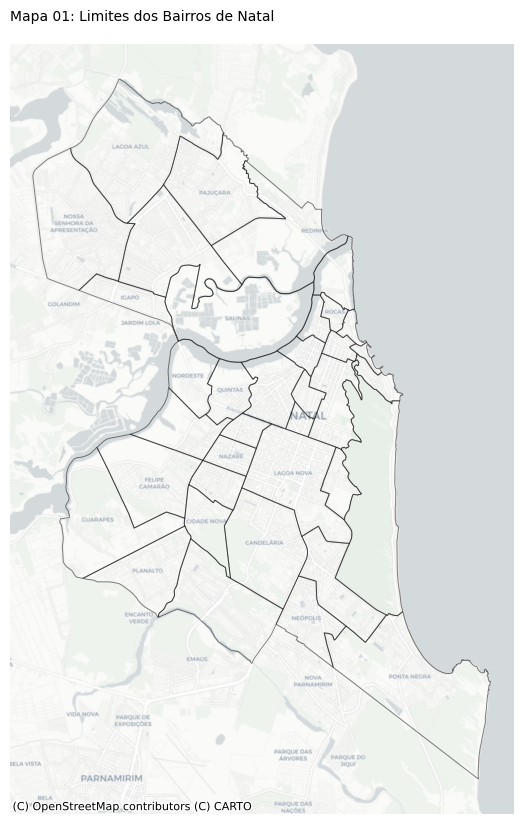

In [26]:
# parametros do mapa
titulo_do_mapa = 'Mapa 01: Limites dos Bairros de Natal'
resolucao_dpi = 'figure'
tamanho_do_mapa = (10,10)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

# adicionando cartografia base
cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

plt.show()

##### **7.2. Qual a distribuição geográfica dos setores censitários em Natal?**

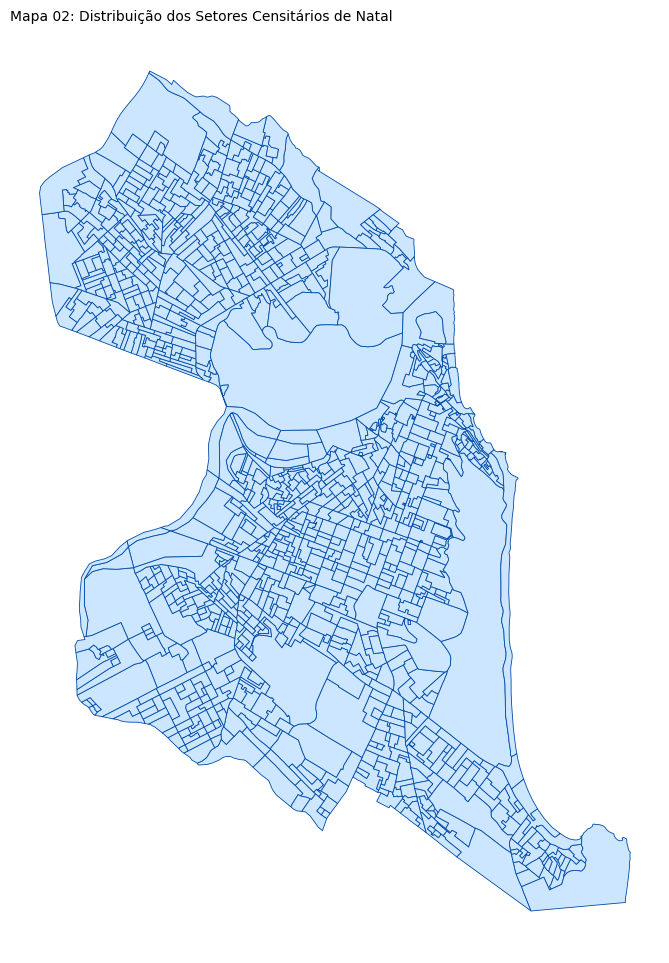

In [27]:
titulo_do_mapa = 'Mapa 02: Distribuição dos Setores Censitários de Natal'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# malha de setores censitarios
gdf_setores_natal.plot(ax=ax,lw=.6, edgecolor='#004BA6', color='#CCE6FF')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

plt.show()

##### **7.3. Qual a distribuição geográfica da infraestrutura cicloviária em Natal?**

In [28]:
gdf_infraestrutura.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
gdf_bairros.crs

<Projected CRS: PROJCS["UTM_Zone_25_Southern_Hemisphere",GEOGCS["G ...>
Name: UTM_Zone_25_Southern_Hemisphere
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 25S
- method: Transverse Mercator
Datum: Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

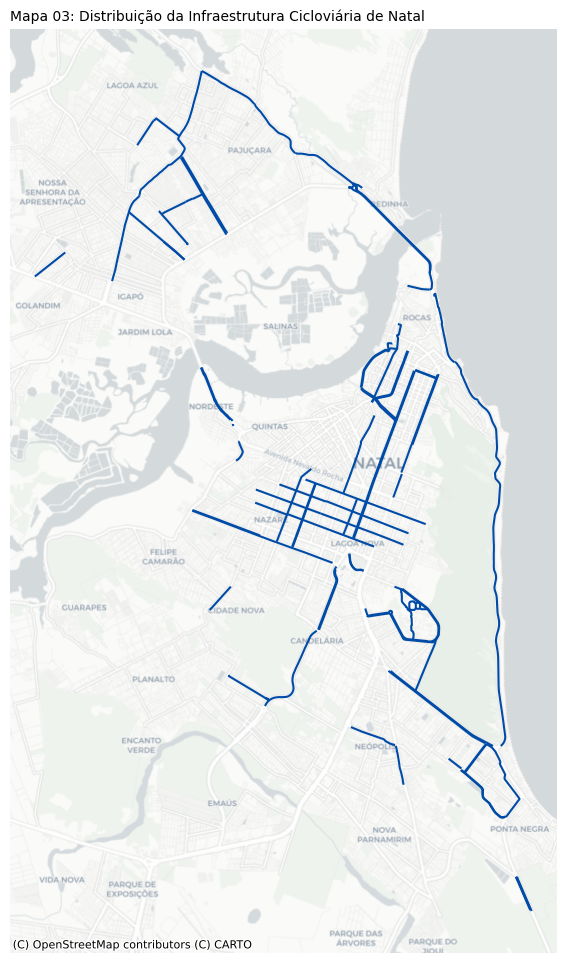

In [30]:
titulo_do_mapa = 'Mapa 03: Distribuição da Infraestrutura Cicloviária de Natal'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# adicionando camada de infraestrutura cicloviaria
gdf_infraestrutura.plot(ax=ax, color='#004BA6')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_infraestrutura.crs, zoom=13, source='CartoDB positron')

plt.show()

Natal conta atualmente com a seguinte infraestrutura:
- 72,72 km (município)
- 31,31 km (outros órgãos)

**Total:** 104,04 km

##### **7.4. Qual o percentual da população de Natal que habita a pelo menos 300m de infraestrutura cicloviária?**

######**7.4.1. Buffer de 300m da infraestrutura cicloviária**

In [31]:
# filtro das colunas de gdf_infraestrutura
df_infraestrutura = gdf_infraestrutura[['Name','geometry']]

# definindo sistema de coordenadas que represente a infraestrutura em um sistema cartesiano
projected_crs = "EPSG:3310"
projected_infraestrutura = df_infraestrutura.to_crs(projected_crs)

# realizando buffer de 300m
infraestrutura_buffer = projected_infraestrutura.buffer(distance=300)

# retornando ao sistema de coordenadas padrao
infraestrutura_buffer = infraestrutura_buffer.to_crs(gdf_infraestrutura.crs)

Para mais informações sobre a transformação de um sistema de coordenadas geográficas para projetadas (sistema cartesiano), acesse este [link](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/geographic-vs-projected-coordinate-reference-systems-python/).

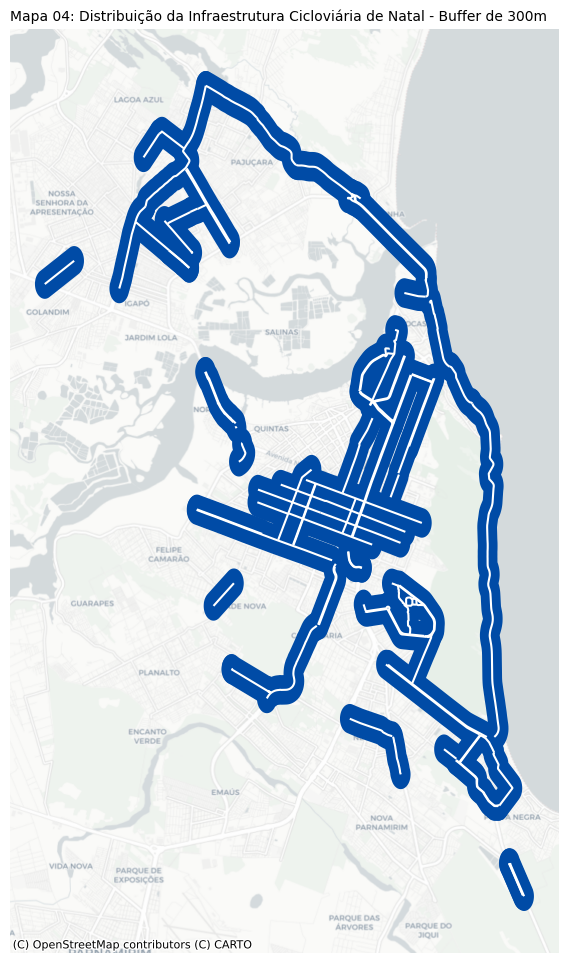

In [32]:
titulo_do_mapa = 'Mapa 04: Distribuição da Infraestrutura Cicloviária de Natal - Buffer de 300m'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
#gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# malha de infraestrutura com buffer de 300m
infraestrutura_buffer.plot(ax=ax, color='#004BA6')

# malha de infraestrutura
gdf_infraestrutura.plot(ax=ax, color='white')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_infraestrutura.crs, zoom=13, source='CartoDB positron')

plt.show()

###### **7.4.2. Interseção da infraestrutura com os setores**

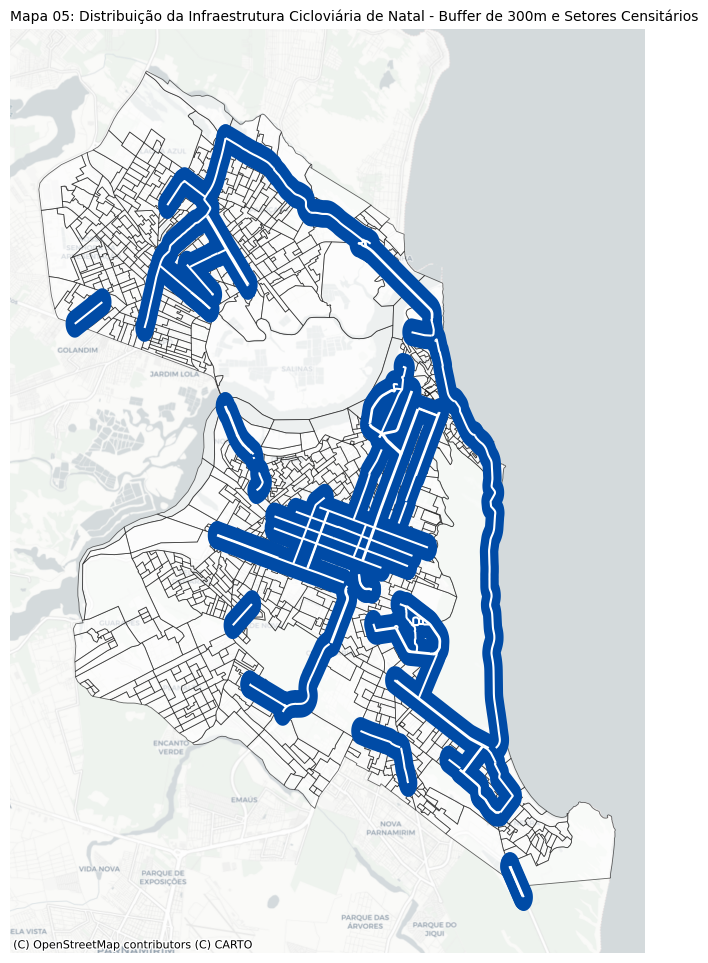

In [33]:
titulo_do_mapa = 'Mapa 05: Distribuição da Infraestrutura Cicloviária de Natal - Buffer de 300m e Setores Censitários'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# malha de setores censitarios
gdf_setores_natal.plot(ax=ax,lw=.6, edgecolor='black', alpha=0.6, facecolor='white')

# malha de infraestrutura com buffer de 300m
infraestrutura_buffer.plot(ax=ax, color='#004BA6')

# malha de infraestrutura
gdf_infraestrutura.plot(ax=ax, color='white')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_infraestrutura.crs, zoom=13, source='CartoDB positron')

plt.show()

Transformação dos polígonos de infraestrutura cicloviária dilatados em um polígono único, de geometria *MultiPolygon*, para não haver sobreposição de polígonos no cálculo do indicador.

In [34]:
# transformacao para DataFrame para substituir nome de coluna a posteriori
df_infraestrutura_buffered = infraestrutura_buffer.to_frame().reset_index()

# substituicao do nome da coluna
df_infraestrutura_buffered.rename(columns={0:'geometry'}, inplace=True)

# transformando para GeoDataframe
gdf_infraestrutura_buffered = df_infraestrutura_buffered.set_geometry('geometry')

# conversao da infraestrutura cicloviaria em um poligono unico
infraestrutura_union = gdf_infraestrutura_buffered.buffer(0).unary_union

**Resultado:**

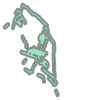

In [35]:
infraestrutura_union

In [36]:
# definindo sistema de referencia de coordenadas
gdf_infraestrutura_union = gpd.GeoDataFrame(geometry=[infraestrutura_union], crs='EPSG:4326')

In [37]:
gdf_infraestrutura_union

geometry
0  MULTIPOLYGON (((-35.24196 -5.85414, -35.24213 ...

In [38]:
# recortando areas dos setores censitarios em interseccao com a infraestrutura
setores_intersection = gdf_setores_natal.overlay(gdf_infraestrutura_union, how='intersection')

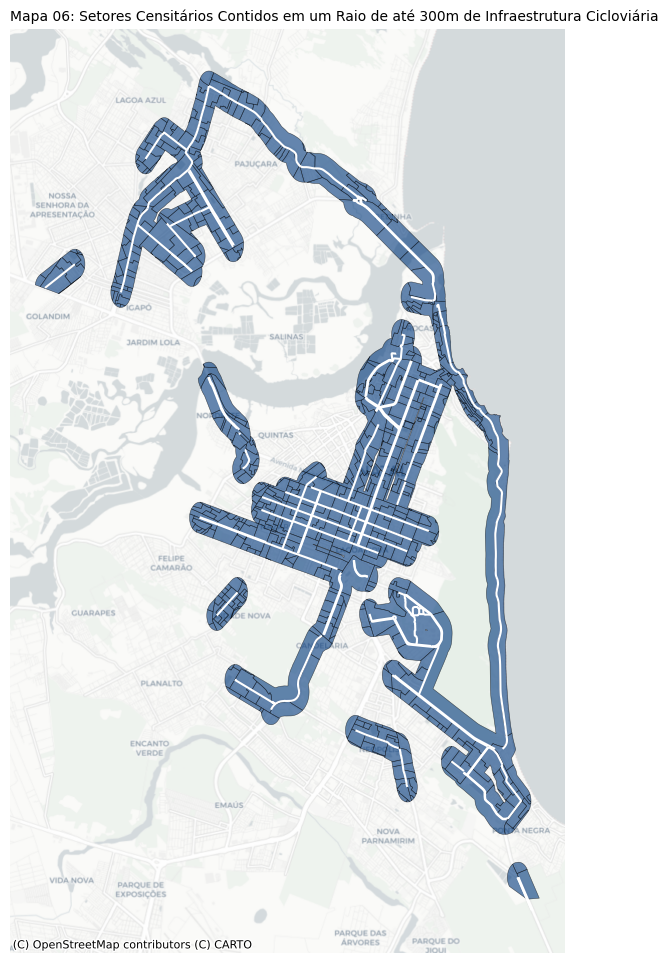

In [39]:
titulo_do_mapa = 'Mapa 06: Setores Censitários Contidos em um Raio de até 300m de Infraestrutura Cicloviária'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# malha de setores intersecionados
setores_intersection.plot(ax=ax,lw=.4, edgecolor='black', alpha=0.6, facecolor='#00387d')

# malha de infraestrutura cicloviaria
gdf_infraestrutura.plot(ax=ax, color='white')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_infraestrutura.crs, zoom=13, source='CartoDB positron')

# salvando no formato PNG
plt.savefig(fname='MapaInfraestruturaSetores.png',
            dpi=600,
            format='png',
            bbox_inches='tight')

plt.show()

###### **7.4.3. Cálculo do proporcional população por área de setor censitário intersecionado**

In [40]:
gdf_setores_natal.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CD_SETOR   1116 non-null   object  
 1   AREA_KM2   1116 non-null   float64 
 2   POPULACAO  1116 non-null   int64   
 3   geometry   1116 non-null   geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 35.0+ KB


In [41]:
setores_intersection.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CD_SETOR   625 non-null    object  
 1   AREA_KM2   625 non-null    float64 
 2   POPULACAO  625 non-null    int64   
 3   geometry   625 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 19.7+ KB


In [42]:
# definindo sistema de coordenadas que represente os setores em um plano cartesiano
projected_crs = "EPSG:3310"
gdf_setores_completos = gdf_setores_natal.to_crs(projected_crs)
gdf_setores_intersecionados = setores_intersection.to_crs(projected_crs)

# adicionando area dos setores intersecionados
gdf_setores_intersecionados['AREA_INTERSECAO'] = gdf_setores_intersecionados.geometry.area

# adicionando area dos setores completos
gdf_setores_completos['AREA_TOTAL_SETOR'] = gdf_setores_completos.geometry.area

# junção dos DataFrames de setores completos e intersecionados
df_join = pd.merge(gdf_setores_completos,
                   gdf_setores_intersecionados,
                   on='CD_SETOR',
                   how='left')

# renomeando as colunas
df_join.rename(columns={'POPULACAO_x':'POPULACAO_SETOR',
                        'geometry_x':'geometry'}, inplace=True)

# excluindo colunas
df_join.drop(columns=['AREA_KM2_x','AREA_KM2_y','POPULACAO_y','geometry_y'], inplace=True)

# calculando dos proporcionais das areas que estao intersecionadas
df_join['PERCENTUAL_AREA'] = df_join['AREA_INTERSECAO']/df_join['AREA_TOTAL_SETOR']

# calculando populacao proporcional nas areas intersecionadas
df_join['POPULACAO_PROPORCIONAL'] = round(df_join['POPULACAO_SETOR'] * df_join['PERCENTUAL_AREA'], 0)

**Resultado:**

In [43]:
df_join.tail()

CD_SETOR  POPULACAO_SETOR  \
1111  240810205090356P              861   
1112  240810205090357P              849   
1113  240810205090358P              698   
1114  240810205090359P              754   
1115  240810205090360P              698   

                                               geometry  AREA_TOTAL_SETOR  \
1111  POLYGON ((10020603.721 260704.937, 10020511.67...      87753.763862   
1112  POLYGON ((10019411.679 265734.843, 10019384.44...      24014.385844   
1113  POLYGON ((10019463.491 266120.737, 10019544.74...      50641.360407   
1114  POLYGON ((10018792.413 262900.381, 10018792.10...      45495.099371   
1115  POLYGON ((10019105.781 262980.005, 10019116.74...      53175.159141   

      AREA_INTERSECAO  PERCENTUAL_AREA  POPULACAO_PROPORCIONAL  
1111              NaN              NaN                     NaN  
1112     24014.385844              1.0                   849.0  
1113     50641.360407              1.0                   698.0  
1114              NaN              NaN                     NaN  
1115              NaN              NaN                     NaN

In [44]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CD_SETOR                1116 non-null   object  
 1   POPULACAO_SETOR         1116 non-null   int64   
 2   geometry                1116 non-null   geometry
 3   AREA_TOTAL_SETOR        1116 non-null   float64 
 4   AREA_INTERSECAO         625 non-null    float64 
 5   PERCENTUAL_AREA         625 non-null    float64 
 6   POPULACAO_PROPORCIONAL  625 non-null    float64 
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 61.2+ KB


**Nota:** A escolha do **Left Join** foi feita para garantir que, mesmo que não haja setores censitários que se sobreponham à infraestrutura cicloviária, eles ainda apareçam no dataframe resultante.

In [45]:
# preenchendo NaN com zero
df_join.fillna(0, inplace=True)

###### **7.4.4. People Near Bike Lanes (PNB)**

Total da população de Natal que está a pelo menos 300m de infraestrutura cicloviária.

In [46]:
populacao_natal = df_setores_natal.POPULACAO.sum()
populacao_natal

751300

In [47]:
PNB = sum(df_join['POPULACAO_PROPORCIONAL'])/populacao_natal

print(f'People Near Bike Lanes - {round(PNB*100,1)}% da população de Natal')

People Near Bike Lanes - 36.5% da população de Natal


##### **7.5. Qual o percentual da população por bairro que habita a pelo menos 300m de infraestrutura cicloviária em Natal?**

In [48]:
gdf_setores_natal.head()

CD_SETOR  AREA_KM2  POPULACAO  \
0  240810205060001P  0.086294        506   
1  240810205060002P  0.104618        854   
2  240810205060003P  0.098724        918   
3  240810205060004P  0.089994       1008   
4  240810205060005P  0.074237        920   

                                            geometry  
0  POLYGON ((-35.25024 -5.75220, -35.25006 -5.752...  
1  POLYGON ((-35.25041 -5.74773, -35.25036 -5.747...  
2  POLYGON ((-35.25305 -5.74715, -35.25338 -5.747...  
3  POLYGON ((-35.25130 -5.74646, -35.25106 -5.746...  
4  POLYGON ((-35.25220 -5.74283, -35.25184 -5.743...

In [49]:
# criando coluna de ponto representativo para cada setor censitario
gdf_setores_natal['representative_point'] = gdf_setores_natal.representative_point()

# criando GeoDataFrame a partir da geometria dos pontos representativos
gdf_points = gpd.GeoDataFrame(gdf_setores_natal, geometry='representative_point')

# conversao de sistema de referencia de coordenadas
gdf_points = gdf_points.to_crs(gdf_bairros.crs)

**Resultado:**

In [50]:
gdf_points.head()

CD_SETOR  AREA_KM2  POPULACAO  \
0  240810205060001P  0.086294        506   
1  240810205060002P  0.104618        854   
2  240810205060003P  0.098724        918   
3  240810205060004P  0.089994       1008   
4  240810205060005P  0.074237        920   

                                            geometry  \
0  POLYGON ((-35.25024 -5.75220, -35.25006 -5.752...   
1  POLYGON ((-35.25041 -5.74773, -35.25036 -5.747...   
2  POLYGON ((-35.25305 -5.74715, -35.25338 -5.747...   
3  POLYGON ((-35.25130 -5.74646, -35.25106 -5.746...   
4  POLYGON ((-35.25220 -5.74283, -35.25184 -5.743...   

             representative_point  
0  POINT (250597.951 9363834.335)  
1  POINT (250513.208 9364074.242)  
2  POINT (250259.886 9364227.849)  
3  POINT (250531.436 9364347.356)  
4  POINT (250426.019 9364752.096)

###### **7.5.1. Adicionando bairros aos setores censitários**

In [51]:
gdf_bairros.head()

id           bairro                                           geometry
0   9            Rocas  POLYGON ((256848.065 9361403.003, 256791.200 9...
1  11    Praia do Meio  POLYGON ((257073.088 9361374.537, 257074.693 9...
2  34         Neópolis  POLYGON ((256774.934 9350774.711, 256732.016 9...
3  35      Capim Macio  POLYGON ((256758.629 9353564.405, 256880.038 9...
4  26  Nova Descoberta  POLYGON ((257075.549 9355457.924, 257105.533 9...

In [52]:
gdf_points.head()

CD_SETOR  AREA_KM2  POPULACAO  \
0  240810205060001P  0.086294        506   
1  240810205060002P  0.104618        854   
2  240810205060003P  0.098724        918   
3  240810205060004P  0.089994       1008   
4  240810205060005P  0.074237        920   

                                            geometry  \
0  POLYGON ((-35.25024 -5.75220, -35.25006 -5.752...   
1  POLYGON ((-35.25041 -5.74773, -35.25036 -5.747...   
2  POLYGON ((-35.25305 -5.74715, -35.25338 -5.747...   
3  POLYGON ((-35.25130 -5.74646, -35.25106 -5.746...   
4  POLYGON ((-35.25220 -5.74283, -35.25184 -5.743...   

             representative_point  
0  POINT (250597.951 9363834.335)  
1  POINT (250513.208 9364074.242)  
2  POINT (250259.886 9364227.849)  
3  POINT (250531.436 9364347.356)  
4  POINT (250426.019 9364752.096)

In [53]:
# padronizando sistema de referencia de coordenadas
gdf_points = gdf_points.to_crs(gdf_bairros.crs)

# implementando spatial join para adicionar geometria de bairros
gdf_setores_bairros = gdf_points.sjoin(gdf_bairros,how='left')

# removendo colunas desnecessarias
gdf_setores_bairros = gdf_setores_bairros.drop(columns=['index_right','id'])

# adicionando coluna de bairros no dataframe de intersecao a partir dos setores completos
df_intersection_bairros = df_join.merge(gdf_setores_bairros[['CD_SETOR','bairro']], how='left')

# renomeando coluna do dataframe de intersecao
df_intersection_bairros = df_intersection_bairros.rename(columns={'bairro':'BAIRRO'})

**Resultado:**

In [54]:
gdf_setores_bairros.head()

CD_SETOR  AREA_KM2  POPULACAO  \
0  240810205060001P  0.086294        506   
1  240810205060002P  0.104618        854   
2  240810205060003P  0.098724        918   
3  240810205060004P  0.089994       1008   
4  240810205060005P  0.074237        920   

                                            geometry  \
0  POLYGON ((-35.25024 -5.75220, -35.25006 -5.752...   
1  POLYGON ((-35.25041 -5.74773, -35.25036 -5.747...   
2  POLYGON ((-35.25305 -5.74715, -35.25338 -5.747...   
3  POLYGON ((-35.25130 -5.74646, -35.25106 -5.746...   
4  POLYGON ((-35.25220 -5.74283, -35.25184 -5.743...   

             representative_point   bairro  
0  POINT (250597.951 9363834.335)  Potengi  
1  POINT (250513.208 9364074.242)  Potengi  
2  POINT (250259.886 9364227.849)  Potengi  
3  POINT (250531.436 9364347.356)  Potengi  
4  POINT (250426.019 9364752.096)  Potengi

In [55]:
df_intersection_bairros.head(5)

CD_SETOR  POPULACAO_SETOR  \
0  240810205060001P              506   
1  240810205060002P              854   
2  240810205060003P              918   
3  240810205060004P             1008   
4  240810205060005P              920   

                                            geometry  AREA_TOTAL_SETOR  \
0  POLYGON ((10013349.041 266635.081, 10013390.68...      86293.633237   
1  POLYGON ((10013019.726 266870.489, 10013029.84...     104617.736426   
2  POLYGON ((10012754.119 266623.966, 10012745.91...      98723.584284   
3  POLYGON ((10012854.158 266847.975, 10012897.10...      89994.289626   
4  POLYGON ((10012522.909 266959.091, 10012588.11...      74237.202708   

   AREA_INTERSECAO  PERCENTUAL_AREA  POPULACAO_PROPORCIONAL   BAIRRO  
0     84701.990943         0.981556                   497.0  Potengi  
1    104617.736426         1.000000                   854.0  Potengi  
2     59566.858746         0.603370                   554.0  Potengi  
3     48301.157233         0.536714                   541.0  Potengi  
4     67879.251458         0.914356                   841.0  Potengi

In [56]:
# calculo da populacao por bairro
df_intersection_bairros.groupby(by='BAIRRO').sum(numeric_only=True).POPULACAO_SETOR

BAIRRO
Alecrim                 21976
Areia Preta              3349
Barro Vermelho           8439
Bom Pastor              15585
Candelária              19947
Capim Macio             22358
Cidade Alta              5345
Cidade Nova             12894
Cidade da Esperança     18059
Dix-Sept Rosado         12865
Felipe Camarão          45254
Guarapes                16923
Igapó                   21293
Lagoa Azul              55607
Lagoa Nova              35725
Lagoa Seca               5628
Mãe Luiza               12295
N.S. da Apresentação    76177
N.S. do Nazaré          15052
Neópolis                23352
Nordeste                 8068
Nova Descoberta          9774
Pajuçara                56454
Parque das Dunas          585
Petrópolis               5401
Pitimbu                 24488
Planalto                37166
Ponta Negra             35151
Potengi                 47824
Praia do Meio            3671
Quintas                 21079
Redinha                 15115
Ribeira                  2699
Rocas                    8973
Salinas                  1814
Santos Reis              4121
Tirol                   19566
Name: POPULACAO_SETOR, dtype: int64

In [57]:
# agrupamento por bairro dos setores censitários intersecionados
df_group_intersection = df_intersection_bairros.groupby(by='BAIRRO').sum(numeric_only=True)

# adequacao do dataframe de agrupamento
df_group_intersection.reset_index(inplace=True)
df_group_intersection.drop('PERCENTUAL_AREA', axis=1, inplace=True)
df_group_intersection.head()

BAIRRO  POPULACAO_SETOR  AREA_TOTAL_SETOR  AREA_INTERSECAO  \
0         Alecrim            21976      3.442037e+06     6.871485e+05   
1     Areia Preta             3349      3.701398e+05     3.655801e+05   
2  Barro Vermelho             8439      9.552810e+05     9.333216e+05   
3      Bom Pastor            15585      3.187935e+06     7.182536e+05   
4      Candelária            19947      9.136137e+06     2.167533e+06   

   POPULACAO_PROPORCIONAL  
0                  5726.0  
1                  3259.0  
2                  8304.0  
3                  7848.0  
4                  4363.0

###### **7.5.2. Cálculo do PNB por bairro de Natal**

In [58]:
# calculo do PNB. por bairro
df_group_intersection['PNB'] = df_group_intersection['POPULACAO_PROPORCIONAL']/df_group_intersection['POPULACAO_SETOR']

# salvando em um arquivo CSV
df_group_intersection.sort_values(by='PNB', ascending=False).to_csv('202407_PNB_Bairro_Natal.csv', index=False, encoding='utf-8')

# adicionando geometria dos bairros para visualizacao do mapa coropletico
geometria_bairros = gdf_bairros[['bairro','geometry']].rename(columns={'bairro':'BAIRRO'})
df_group_intersection = df_group_intersection.merge(geometria_bairros, on='BAIRRO', how='left')
gdf_group_intersection = gpd.GeoDataFrame(df_group_intersection, geometry='geometry')

###### **7.5.3. Mapa Coroplético da Distribuição do Indicador PNB por Bairro**

In [59]:
quantis=5
titulo_do_mapa = 'Figura 06: Distribuição do Percentual de Pessoas que Vivem Até 300m de Infraestrutura Cicloviária em Natal'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)
colors = ['#CCE6FF', '#A0CAFF', '#75AEFF', '#4A92FF', '#1E77FF', '#005BC9', '#004BA6', '#00387D', '#002654', '#00132B']
paleta_coropletico = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
missing = {'color':'darkgrey',
            'edgecolor':'grey',
            'label':'Sem informações'}


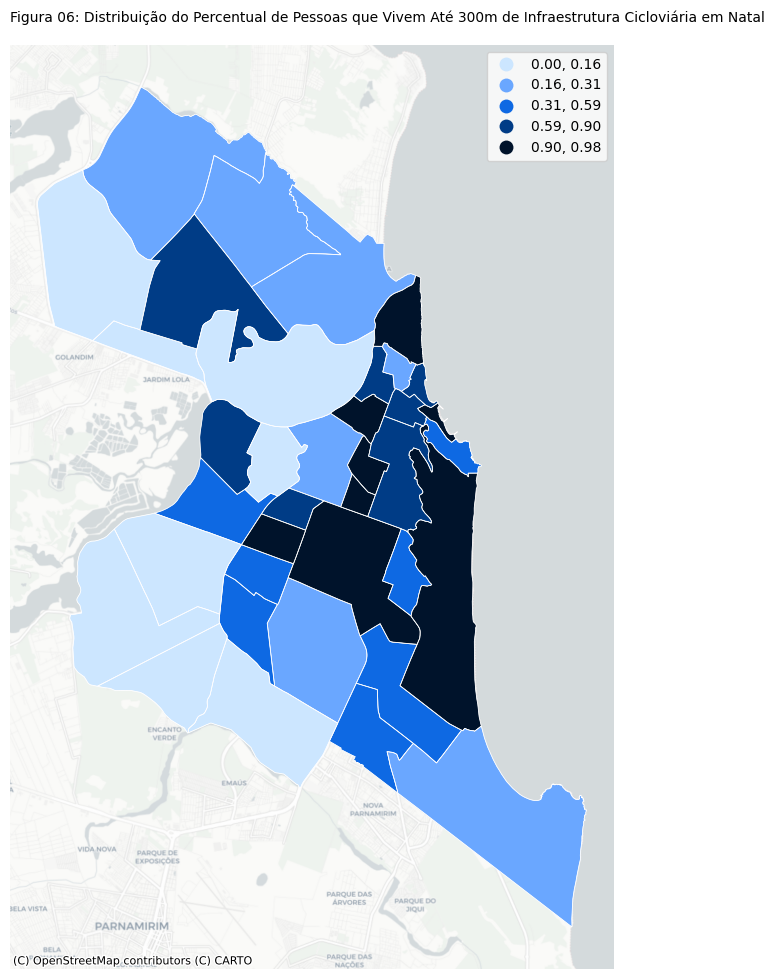

In [60]:
# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='white', linewidth=.2, alpha=.8)

# camada do mapa coropletico
gdf_group_intersection.plot(ax = ax,
                            scheme = 'quantiles',
                            column = 'PNB',
                            k = quantis,
                            lw = .6,
                            edgecolor='white',
                            cmap = paleta_coropletico,
                            legend = True)

plt.title(titulo_do_mapa, loc='left', fontsize=10)

plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

# salvando no formato PNG
plt.savefig(fname='MapaCoropleticoPNB.png',
            dpi=600,
            format='png',
            bbox_inches='tight')

plt.show()

#### **8. Visualizações Interativas**

In [61]:
m = folium.Map(location=(-5.7842,-35.2000),
               zoom_start=11,
               tiles='CartoDB positron')

folium.Choropleth(
    geo_data=gdf_group_intersection,
    name='choropleth',
    data=gdf_group_intersection,
    columns=['BAIRRO', 'PNB'],
    key_on='feature.properties.BAIRRO',
    fill_color='YlGnBu',
    fill_opacity=0.3,
    line_weight=1,
).add_to(m)

folium.plugins.Geocoder().add_to(m)

m

In [62]:
m = folium.Map(location=(-5.7842,-35.2000),
               zoom_start=11,
               tiles='CartoDB positron')

folium.Choropleth(
    geo_data=gdf_group_intersection,
    name='choropleth',
    data=gdf_group_intersection,
    columns=['BAIRRO', 'PNB'],
    key_on='feature.properties.BAIRRO',
    fill_color='YlGnBu',
    fill_opacity=0.3,
    line_weight=.5,
).add_to(m)

folium.GeoJson(
    gdf_infraestrutura,
    name='Infraestrutura cicloviária',
).add_to(m)

#folium.plugins.Geocoder().add_to(m)

m

In [63]:
m = folium.Map(location=(-5.7842,-35.2000),
               zoom_start=11,
               tiles='CartoDB positron')

folium.GeoJson(
    gdf_bairros,
    name='Bairros',
    zoom_on_click=True,
    style_function=lambda feature: {
        "fillColor": "white",
        "color": "grey",
        "weight": 0.5,
        "fillOpacity": 0,
    },
).add_to(m)

folium.GeoJson(
    gdf_infraestrutura,
    name='Infraestrutura cicloviária',
    color='#004BA6',
    fill_opacity=2
).add_to(m)

m

#### **Extra**

**Histograma do PNB nos bairros de Natal**

In [64]:
# metadados do histograma do indicador PNB
df = gdf_group_intersection
indicator = 'PNB'
bins=5
min = df[indicator].min()
max = df[indicator].max()

# histograma
histogram = np.histogram(df[indicator], range=(min,max), bins=bins)

# dataframe contendo os intervalos e contagem de bairros
df_histogram = pd.DataFrame()
df_histogram['limiar'] = histogram[1][1:]
df_histogram['count_bairros'] = histogram[0]
df_histogram['limiar'] = round(df_histogram['limiar'],2)

In [65]:
df_histogram

limiar  count_bairros
0    0.20              8
1    0.39             10
2    0.59              4
3    0.79              4
4    0.98             11

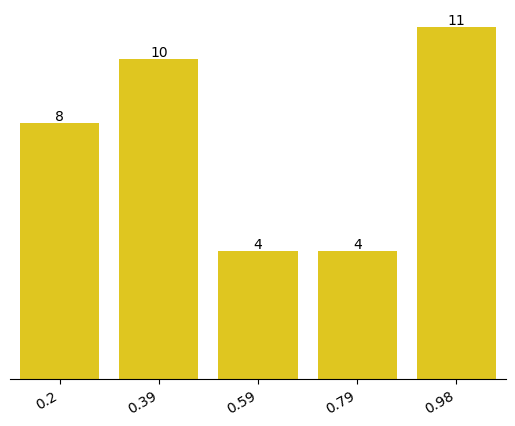

In [66]:
ax = sns.barplot(data=df_histogram,
                 x='limiar',
                 y='count_bairros',
                 color='#ffdd00')

ax.bar_label(ax.containers[0], fontsize=10);

# removendo linhas de eixos
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_visible(False)

# removendo label do eixo x
ax.set_xlabel('')

ax.set_xticks(np.arange(len(df_histogram['limiar'])))
ax.set_xticklabels(df_histogram['limiar'], rotation=30, ha='right')

plt.show()

In [67]:
df_histogram.to_csv('202404_HistogramaProximidadeCiclo.csv',
                    encoding='utf-8',
                    index=False)

**Obrigado!** 🌞